In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [0]:
start = datetime.datetime(2010, 1, 1)
end = datetime.date.today()

In [0]:
df = web.DataReader("GS", 'yahoo', start, end)

In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-09,213.880005,208.440002,209.220001,211.979996,2734500.0,211.979996
2019-09-10,217.089996,213.220001,213.500000,215.630005,2615800.0,215.630005
2019-09-11,216.850006,213.360001,215.210007,216.800003,1886300.0,216.800003
2019-09-12,220.759995,215.149994,216.380005,218.740005,2913800.0,218.740005
2019-09-13,221.500000,219.199997,220.350006,219.899994,2679900.0,219.899994


In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [6]:
mavg.tail()

Date
2019-09-09    200.867713
2019-09-10    200.967250
2019-09-11    201.098174
2019-09-12    201.261458
2019-09-13    201.440892
Name: Adj Close, dtype: float64

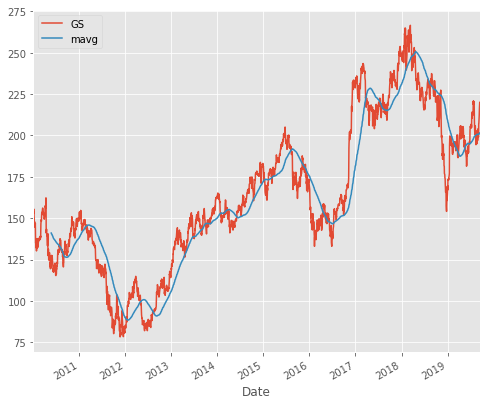

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

#Adjusting the siye of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8,7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='GS')
mavg.plot(label='mavg')
plt.legend()

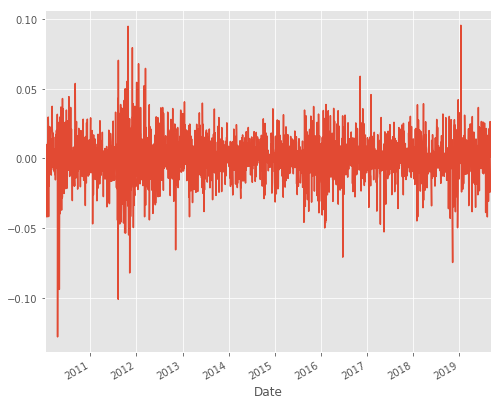

In [8]:
rets = close_px / close_px.shift(1)-1
rets.plot(label='return')

In [0]:
dfcomp = web.DataReader(['GS','MS','JPM','UBS','BCS','BAC'],'yahoo',start=start,end=end)['Adj Close']

In [10]:
dfcomp.tail()

Symbols,BAC,BCS,GS,JPM,MS,UBS
Date,,,,,,
2019-09-09,28.629999,6.96,211.979996,115.400002,43.110001,11.14
2019-09-10,29.350000,7.31,215.630005,116.870003,43.580002,11.49
2019-09-11,29.459999,7.36,216.800003,117.190002,43.939999,11.58
2019-09-12,29.670000,7.36,218.740005,117.910004,44.320000,11.53
2019-09-13,30.170000,7.77,219.899994,120.230003,45.160000,11.73


In [0]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()

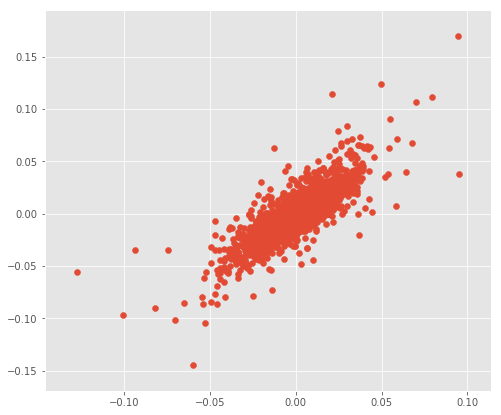

In [13]:
plt.scatter(retscomp.GS, retscomp.MS)

In [14]:
retscomp.tail()

Symbols,BAC,BCS,GS,JPM,MS,UBS
Date,,,,,,
2019-09-09,0.032456,0.013100,0.023020,0.024776,0.022048,0.023897
2019-09-10,0.025148,0.050287,0.017219,0.012738,0.010902,0.031418
2019-09-11,0.003748,0.006840,0.005426,0.002738,0.008261,0.007833
2019-09-12,0.007128,0.000000,0.008948,0.006144,0.008648,-0.004318
2019-09-13,0.016852,0.055706,0.005303,0.019676,0.018953,0.017346


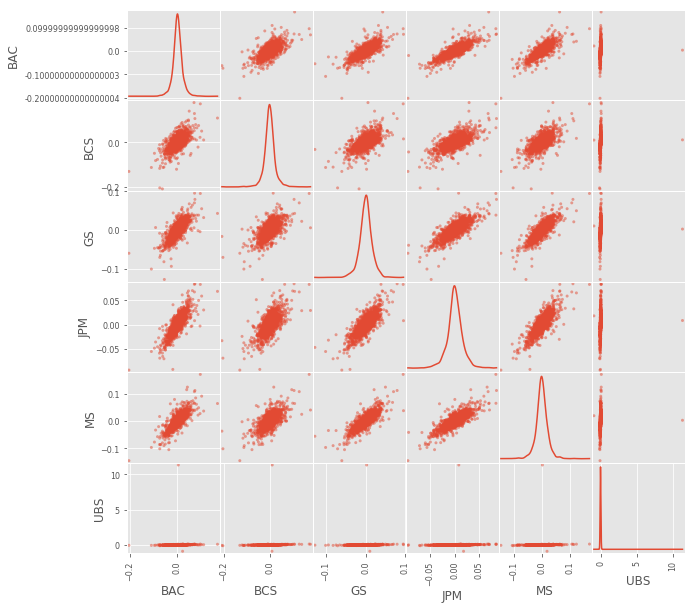

In [15]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10,10));

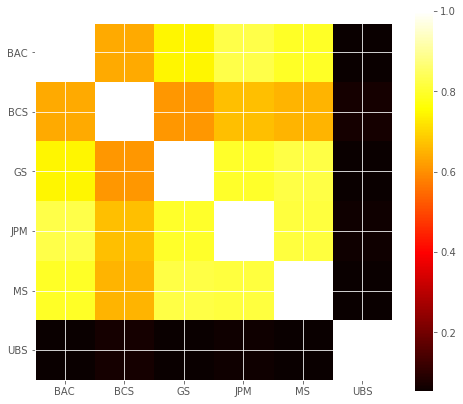

In [16]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

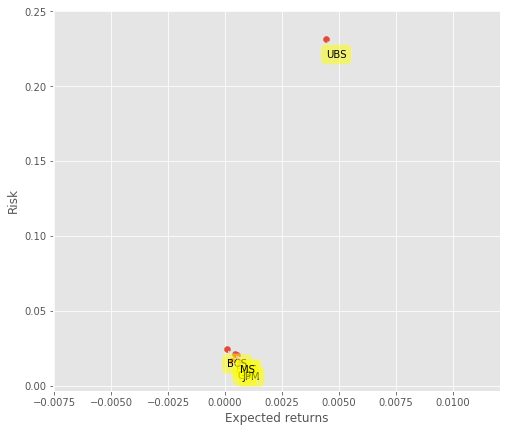

In [17]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
  plt.annotate(
  label,
  xy = (x,y), xytext = (20, -20),
  textcoords = 'offset points', ha = 'right', va = 'bottom',
  bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
  arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
# Feature Engineering

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [0]:
import math
import numpy as np
import sklearn

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [22]:
len(X)

2416

In [23]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [24]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=2, p=2,
          weights='uniform')

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)


In [26]:
confidencereg

0.9117503372395281

In [27]:
confidencepoly2

0.9119761847451112

In [28]:
confidencepoly3

0.892207365724049

In [29]:
confidenceknn

0.8792767664114879

In [0]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

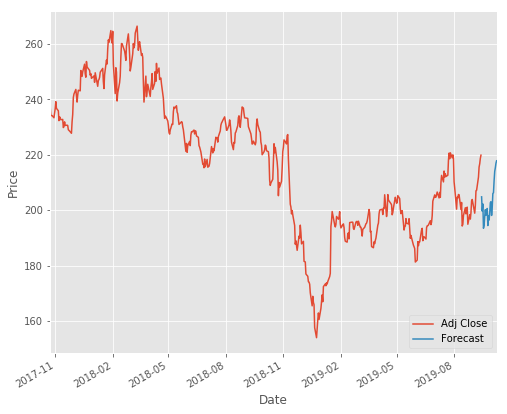

In [31]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()